# $\textit{Detección por voz de sexo}$

$\textit{By Bautista Schneeberger, Agustin Gullino y Gonzalo Linares}$

In [1]:
import os

if not os.path.exists("VoxCeleb_gender"):
    !pip install gdown pydub librosa
    !gdown https://drive.google.com/uc?id=1V3lNnSDv71AJYIj71V4_xD0ir0DrXxEV
    !tar -xf VoxCeleb_gender.zip #!tar -xf VoxCeleb_gender.zip
    !del VoxCeleb_gender.zip     #!del

else:
    print("Dataset already downloaded.")

Dataset already downloaded.


$\textit{Implementación del cálculo de los MFCCs}$

In [88]:
import librosa
import scipy.signal as ss
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
sns.set_theme()

def extract_mfcc(file_path, n_mfcc=12, win_length=320, hop_length=160):
    wave, sr = librosa.load(file_path, mono=True, sr=None)
    if sr != 16000:
        wave = librosa.resample(wave, sr, 16000)
    mfcc = librosa.feature.mfcc(y=wave, sr=16000, n_mfcc=n_mfcc, window=ss.windows.hamming, win_length=win_length, hop_length=hop_length)
    return mfcc

$\textit{Elegimos la cantidad de MFCCs y tamaño de la trama}$

In [89]:
mfcc_coeff_amount = 12
window_length = int(16000*0.02)

In [5]:
arr = []
if not os.path.exists(f"mfcc_{mfcc_coeff_amount}_{window_length}.pkl"):

    aux = []

    for (dirpath, dirnames, filenames) in os.walk("VoxCeleb_gender"):
        for filename in filenames:
            if filename.endswith(".wav"):
                filepath = dirpath + "/" + filename
                aux.append({"file": filepath, "gender": "females" if "females" in dirpath else "males"})

    df = pd.DataFrame(aux)

    df["mfcc"] = pd.Series(name="mfcc", dtype=object)

    for i in range(len(df)):
        mfcc_coeffs = extract_mfcc(df.loc[i, "file"], n_mfcc=mfcc_coeff_amount, win_length=window_length)
        for i, coeffs in enumerate(mfcc_coeffs):
            if np.linalg.norm(coeffs) < 1:
                mfcc_coeffs.pop(i)
        arr.append(mfcc_coeffs)
    df["mfcc"] = arr
    df.to_pickle(f"mfcc_{mfcc_coeff_amount}_{window_length}.pkl")
else:
    print("File Found")
    df = pd.read_pickle(f"mfcc_{mfcc_coeff_amount}_{window_length}.pkl")


num_males = len(df.loc[df.gender == "males"] )           
num_females = len(df.loc[df.gender == "females"] )              

File Found


In [6]:
print("Number of males: ", num_males)
print("Number of females: ", num_females)

Number of males:  3682
Number of females:  2311


In [7]:
display(df) #Cada fila tiene los datos de un audio, cada columna mfcc contiene n_mfcc x timesteps 

,file,gender,mfcc
0,VoxCeleb_gender\females/0.wav,females,"[[-297.64233, -311.51636, -333.22858, -353.112..."
1,VoxCeleb_gender\females/1.wav,females,"[[-237.64122, -249.89484, -260.6425, -261.0365..."
2,VoxCeleb_gender\females/10.wav,females,"[[-442.06046, -442.974, -473.21695, -495.31973..."
3,VoxCeleb_gender\females/100.wav,females,"[[-217.43253, -215.3289, -202.59782, -189.7104..."
4,VoxCeleb_gender\females/1000.wav,females,"[[-310.47504, -292.76688, -310.6037, -303.5888..."
...,...,...,...
5988,VoxCeleb_gender\males/995.wav,males,"[[-486.3795, -482.37906, -486.09213, -493.3973..."
5989,VoxCeleb_gender\males/996.wav,males,"[[-296.01495, -315.97952, -288.9254, -280.0321..."
5990,VoxCeleb_gender\males/997.wav,males,"[[-539.7124, -535.8697, -522.5412, -559.24457,..."
5991,VoxCeleb_gender\males/998.wav,males,"[[-674.96234, -657.79913, -662.2179, -658.7952..."


$\textit{Separamos entre train y test}$

In [8]:
from sklearn.model_selection import train_test_split

#Equalize number of gender in dataset
# gender_counts = df['gender'].value_counts()
# difference = abs(gender_counts['males'] - gender_counts['females'])
# if gender_counts['males'] > gender_counts['females']:
#     df_balanced = df.drop(df[df['gender'] == 'males'].sample(n=difference, random_state=42).index)
# else:
#     df_balanced = df.drop(df[df['gender'] == 'females'].sample(n=difference, random_state=42).index)

#Split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(df.drop(['gender'], axis=1), df['gender'], test_size=0.2)
X_file, X_test_file = X_train["file"], X_test["file"]
X_train.drop(["file"], inplace=True, axis=1)
X_test.drop(["file"], inplace=True, axis=1)


# $\textit{EDA}$

$\textit{Observamos la media de los MFCCs de cada sexo}$

In [36]:
# Get the mean mfcc coefficients for each class
mean_mfcc_males = 0
mean_mfcc_females = 0

for i, person in df.iterrows():
    for j in range(len(person["mfcc"])//mfcc_coeff_amount):
        if person["gender"] == "males":
            mean_mfcc_males += np.mean(np.array(person["mfcc"]), axis=1)/num_males
        else:
            mean_mfcc_females += np.mean(person["mfcc"], axis=1)/num_females

display(mean_mfcc_males)
display(mean_mfcc_females)

array([-343.47223  ,  114.533104 ,    6.7275085,   24.822563 ,
         -2.9240904,   -3.0012898,  -10.198604 ,   -6.582154 ,
         -6.681044 ,   -2.0333934,   -3.6331787,   -1.2945163],
      dtype=float32)

array([-340.25763  ,  103.041245 ,   -1.7812202,   17.898232 ,
        -11.310761 ,   -6.520376 ,  -11.09556  ,   -3.6568515,
         -5.270185 ,   -3.3022828,   -4.401098 ,   -5.8295736],
      dtype=float32)

# $\textit{GMM Model}$

In [44]:
X_male = np.concatenate(X_train.mfcc[y_train=="males"].to_numpy(), axis=1).T
X_female = np.concatenate(X_train.mfcc[y_train=="females"].to_numpy(), axis=1).T
X_test_male = np.concatenate(X_test.mfcc[y_test=="males"].to_numpy(), axis=1).T
X_test_female = np.concatenate(X_test.mfcc[y_test=="females"].to_numpy(), axis=1).T

In [45]:
X_test[y_test=="females"]

,mfcc
1220,"[[-172.28334, -251.54314, -249.48094, -243.260..."
407,"[[-117.172356, -173.89807, -165.34935, -147.50..."
1726,"[[-346.71948, -355.70004, -311.73737, -288.419..."
1406,"[[-194.79532, -229.3259, -251.36617, -282.2349..."
1645,"[[-616.7597, -617.49866, -621.13794, -579.8694..."
...,...
1362,"[[-436.8856, -446.99756, -458.1016, -477.3751,..."
1348,"[[-217.81274, -206.45372, -198.15575, -200.655..."
147,"[[-320.3589, -332.83508, -341.91678, -342.702,..."
15,"[[-285.64926, -299.4173, -312.37546, -354.8849..."


$\textit{Fit Models}$

In [46]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
import pickle


if not os.path.exists(f"gmm_male_mfcc_{mfcc_coeff_amount}_{window_length}.pkl"):
    
    gmm_male = GaussianMixture(n_components=mfcc_coeff_amount, covariance_type='full', max_iter=1000)
    gmm_female = GaussianMixture(n_components=mfcc_coeff_amount, covariance_type='full', max_iter=1000)

    gmm_male.fit(X_male)
    gmm_female.fit(X_female)

    with open(f"gmm_male_mfcc_{mfcc_coeff_amount}_{window_length}.pkl",'wb') as f:
        pickle.dump(gmm_male,f)

    with open(f"gmm_female_mfcc_{mfcc_coeff_amount}_{window_length}.pkl",'wb') as f:
        pickle.dump(gmm_female,f)

else:
    print("File Found")

    with open(f"gmm_male_mfcc_{mfcc_coeff_amount}_{window_length}.pkl",'rb') as f:
        gmm_male = pickle.load(f)

    with open(f"gmm_female_mfcc_{mfcc_coeff_amount}_{window_length}.pkl",'rb') as f:
        gmm_female = pickle.load(f)

File Found


c:\Users\Gonzalo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:299: UserWarning: Trying to unpickle estimator GaussianMixture from version 1.4.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [138]:
female_scores = gmm_female.score_samples(X_test.mfcc.iloc[person].T)
male_scores = gmm_male.score_samples(X_test.mfcc.iloc[person].T)
df_female = pd.DataFrame({'score': female_scores, 'gender': 'females'})
df_male = pd.DataFrame({'score': male_scores, 'gender': 'males'})
df_scores = pd.concat([df_female, df_male])

$\textit{Observamos la distribucion de los scores para cada trama de cada modelo}$

(-80.0, -20.0)

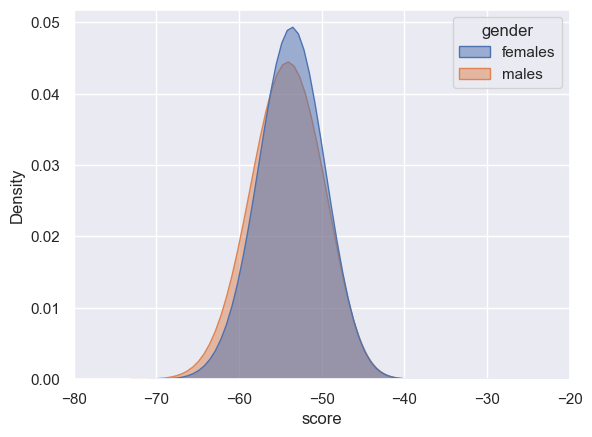

In [158]:
sns.kdeplot(data=df_scores, x='score', hue='gender', alpha=0.5, fill=True)
plt.xlim((-80,-20))

In [153]:
scores_fgmm = pd.Series(index=y_test.index)
scores_mgmm = pd.Series(index=y_test.index)

for index, row in X_test.iterrows():
    mfcc = row['mfcc']
    scores_fgmm[index] = gmm_female.score_samples(mfcc.T).mean()
    scores_mgmm[index] = gmm_male.score_samples(mfcc.T).mean()

mean_scoresf = scores_mgmm[y_test == "females"][:1000]
mean_scoresm = scores_mgmm[y_test == "males"][:1000]
df_female_mean = pd.DataFrame({'score': mean_scoresf, 'gender': 'females'})
df_male_mean = pd.DataFrame({'score': mean_scoresm, 'gender': 'males'})
df_scores_mean = pd.concat([df_female_mean, df_male_mean])

display(scores_fgmm[y_test == "males"].mean())
display(scores_fgmm[y_test == "females"].mean())

C:\Users\Gonzalo\AppData\Local\Temp\ipykernel_11480\3547964259.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  scores_fgmm = pd.Series(index=y_test.index)
C:\Users\Gonzalo\AppData\Local\Temp\ipykernel_11480\3547964259.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  scores_mgmm = pd.Series(index=y_test.index)


-53.675519310396346

-53.02156736260572

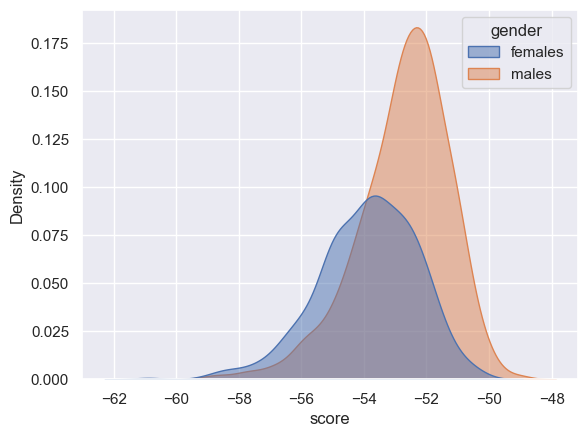

In [154]:
sns.kdeplot(data=df_scores_mean, x='score', hue='gender', alpha=0.5, fill=True);

$\textit{Probamos el modelo sobre el test}$

In [155]:
predictions = []
for index in y_test.index:
    if scores_mgmm[index] > scores_fgmm[index]:
        predictions.append('males')
    else:
        predictions.append('females')

# Convert predictions to a pandas Series
predictions = pd.Series(predictions, index=y_test.index)

# Calculate the accuracy
accuracy = (predictions == y_test).mean()

# Print the accuracy
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 90.58%


$\textit{Probamos el modelo en tiempo real}$

In [103]:
import pyaudio
from IPython.display import update_display

Chunk = 1024 * 8
format = pyaudio.paFloat32
channels = 1
rate = 16000

In [104]:
def predict_male(features):
    score = gmm_male.score_samples(features).mean() - gmm_female.score_samples(features).mean()
    return f"male?: {score>0}, score: {score}"

In [157]:
p = pyaudio.PyAudio()

stream = p.open(
    format=format,
    channels=channels,
    rate=rate,
    input=True,
    output=True,
    frames_per_buffer=Chunk,
)
result = "male"
display(result, display_id="res")
while True:
    data = stream.read(Chunk)
    data_int = np.frombuffer(data, dtype=np.float32)
    features = librosa.feature.mfcc(y=data_int, sr=16000, n_mfcc=mfcc_coeff_amount, window=ss.windows.hamming, win_length=window_length, hop_length=window_length//2).T
    update_display(predict_male(features), display_id="res")



'male?: True, score: 1.9054043463292132'

KeyboardInterrupt: 